# Importing required libraries

In [1]:
# pip install numpy;
# pip install pandas;
# pip install matplotlib
# pip install tensorflow
# pip install pydot
# pip install mlxtend
# pip install opencv-python
# pip install nbconvert

In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import glob
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils.vis_utils import plot_model
from PIL import Image
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2 as cv

# Directories of training , testing & validation data

In [3]:
input_data="chest_xray/"
train_directory= input_data + "train/"
val_directory= input_data + "val/"
test_directory= input_data + "test/"

# Getting the class names

In [4]:
data_dir = train_directory
class_names=os.listdir(train_directory)
print(class_names)

['NORMAL', 'PNEUMONIA']


# Define Constantes

In [5]:
# dir to generate files
FILES_GENERATED = 'files_generated/'
# name of model to save to png file
MODEL_PNG = 'cnn_model.png'
#checkpoint dir
CHECKPOINT_DIR = 'training/'
# name of best model to save
MODEL_SAVED = CHECKPOINT_DIR + 'best_model.h5'
# Default batch size
BATCH_SIZE = 32

# Function to display random images...

In [6]:
def view_random_image(target_directory, target_class):
    target_folder = target_directory + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    return img

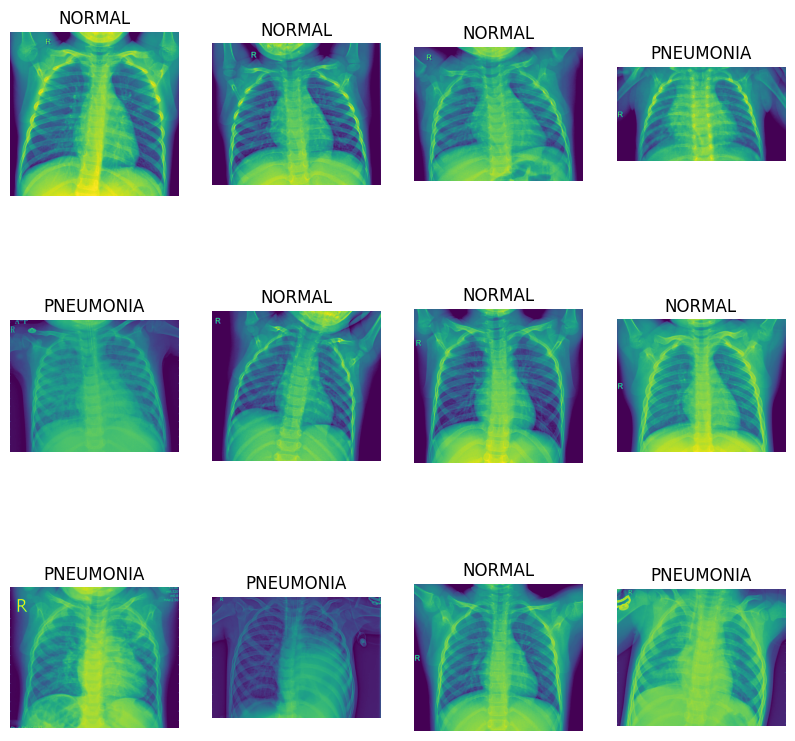

In [7]:
plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(3,4,i+1)
    r=random.randint(0,1)
    img = view_random_image(data_dir, class_names[r])   

# Random vizualization from all directories

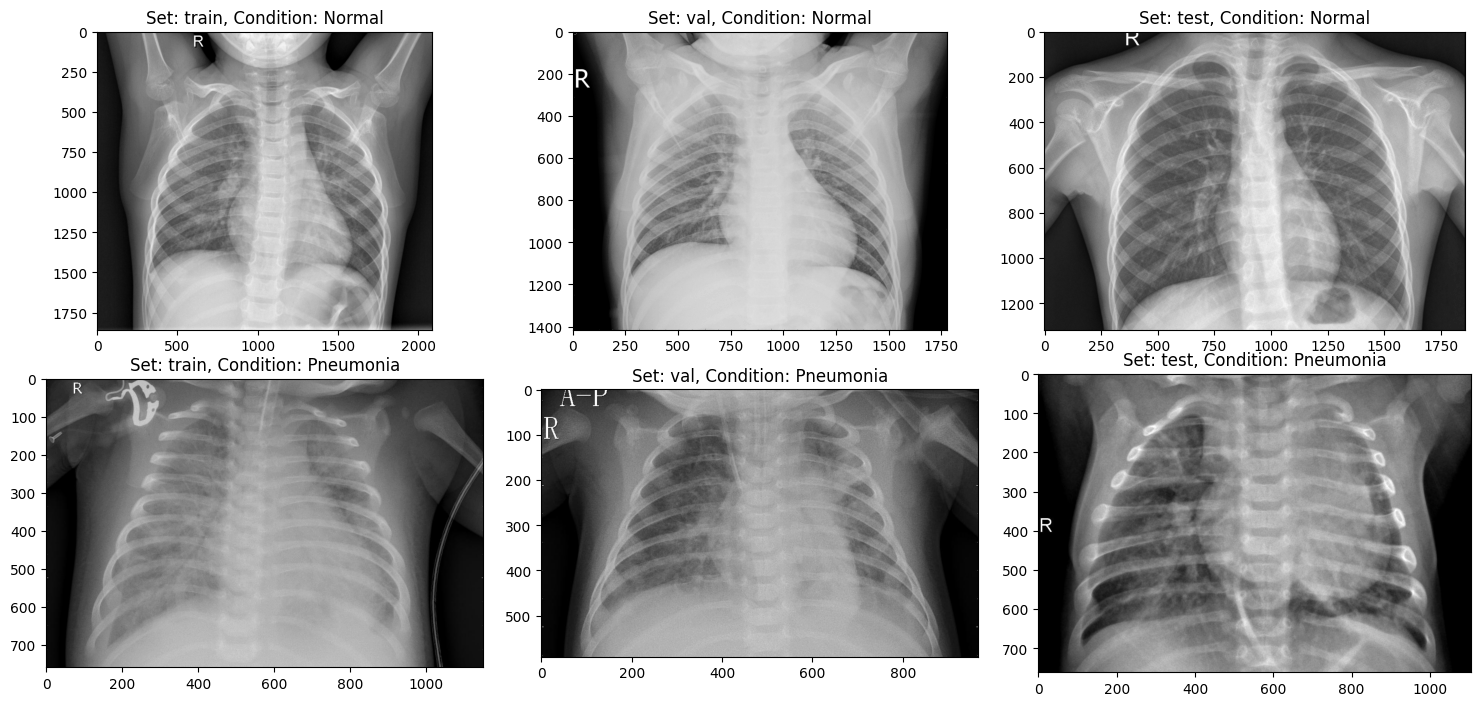

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_data + _set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

# No. of images present in each set

In [9]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_data + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_data + _set + '/PNEUMONIA'))
    print('Set: {}, Normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, Normal images: 1341, pneumonia images: 3875
Set: val, Normal images: 8, pneumonia images: 8
Set: test, Normal images: 234, pneumonia images: 390


# Keras ImageDataGenerator

<p> It is used for getting the input of the original data and further, it makes the transformation of this data on a random basis and gives the output resultant containing only the data that is newly transformed. It does not add the data. Keras image data generator class is also used to carry out data augmentation where we aim to gain the overall increment in the generalization of the model. Operations such as rotations, translations, shearin, scale changes, and horizontal flips are carried out randomly in data augmentation using an image data generator. </p>

![ImageDataGenerator](http://ai.stanford.edu/blog/assets/img/posts/2020-04-20-data-augmentation/fig1.png)

## This is how it looks like
![ImageDataGenerator_sample](https://miro.medium.com/max/1200/1*Ukc49J8TzyxiOD30EqOWwQ.png)


In [10]:
Image_gen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

# Flow from directory

<p> This method is useful when the images are sorted and placed in there respective class/label folders. This method will identify classes automatically from the folder name. </p> 

![Flow from directory](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)

In [13]:
train = Image_gen.flow_from_directory(
    train_directory,
    batch_size=32,
    class_mode='binary',
    )

validation = Image_gen.flow_from_directory(
    val_directory,
    batch_size=2,                                              
    class_mode='binary',
    )

test = val_Datagen.flow_from_directory(
    test_directory,
    batch_size=2,
    class_mode='binary',                         
    )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
img, label = next(train)

# Early Stopping 

<p> In machine learning, early stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method, such as gradient descent. Such methods update the learner so as to make it better fit the training data with each iteration. Up to a point, this improves the learner's performance on data outside of the training set. Past that point, however, improving the learner's fit to the training data comes at the expense of increased generalization error. Early stopping rules provide guidance as to how many iterations can be run before the learner begins to over-fit. Early stopping rules have been employed in many different machine learning methods, with varying amounts of theoretical foundation. </p>

![Early stopping](https://i.stack.imgur.com/LY2wM.png)

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)

# ReduceLROnPlateau

<p> Reduce learning rate when a metric has stopped improving.

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced. </p>

![ReduceLROnPlateau](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/images/lr1.png)

In [16]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=8)

# ResNet50V2 model
**Reference**

[MathWorks resnet50](https://www.mathworks.com/help/deeplearning/ref/resnet50.html)

<p> ResNet-50 is a convolutional neural network that is 50 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database . The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. </p>

![ResNet50](https://www.researchgate.net/publication/363920620/figure/fig2/AS:11431281086998031@1664428512125/Resnet50v2-and-LSTM-based-visual-baseline-models-architecture-The-size-of-the-feature.ppm)

In [17]:
def create_model():
    resnet_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top = False,
        input_shape = (224,224,3)
    )

    for layer in resnet_model.layers:
        layer.trainable=False

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    # output layer
    predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return res_model

In [18]:
res_model = create_model()

In [19]:
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# Converts a Keras model to dot format and save to a file.

In [20]:
plot_model(res_model, to_file=FILES_GENERATED + MODEL_PNG, show_shapes=True, show_layer_names=True)
display(Image.open(FILES_GENERATED + MODEL_PNG))

FileNotFoundError: [Errno 2] No such file or directory: 'cnn_model.png'

# train model

In [ ]:
checkpoint_path = CHECKPOINT_DIR + "cp-{epoch:04d}.ckpt"

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*BATCH_SIZE)

# Create a callback allowing to save the best performing model
checkpoint = ModelCheckpoint(MODEL_SAVED, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = res_model.fit(train,epochs=3, 
                    validation_data=validation,
                    steps_per_epoch=100,
                    callbacks=[early_stopping,lr, checkpoint],
                    batch_size=32)

# Accuracy & Loss each epochs

In [ ]:
#Plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

# Model evaluation with training and testing data

In [ ]:
# Evaluating the model on train and test
score = res_model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = res_model.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

# Conclusion

<p> Our model has an accuracy of 95.8% on the validation set. // todo: check %

On the hold out dataset, the model is performing with an F-Score of 0.91 but what really matters is that it has a recall of 96%!

Meaning that we're not detecting 4% of the malignant patient. On the test dataset, out of 390 malignant patients, the model detected 378 pneumonia.

The trade off is that our model predicted that 27.7% of patient had pneumonia where in fact they were healthy (False Positive). </p>